In [16]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import base64
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from IPython.display import HTML
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("All libraries imported.")

All libraries imported.


In [17]:
# Unzip with overwrite flag
!unzip -o -q /content/Data.zip -d /content/

# Set path and get categories
data_path = '/content/Data/'
categories = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

# Build lists
X, y = [], []
for category in categories:
    path = os.path.join(data_path, category)
    for img in os.listdir(path):
        if img.lower().endswith(('.jpg', '.jpeg', '.png')):
            X.append(os.path.join(path, img))
            y.append(category)

# Split 70/30
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=101)
train_df = pd.DataFrame({'FileName': X_train, 'Category': y_train})
val_df = pd.DataFrame({'FileName': X_val, 'Category': y_val})

print(f"Dataset Ready: {len(train_df)} training images, {len(val_df)} validation images.")

Dataset Ready: 140 training images, 60 validation images.


In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_dataframe(
    train_df, x_col='FileName', y_col='Category',
    target_size=(224, 224), batch_size=32, class_mode='categorical'
)

val_set = val_datagen.flow_from_dataframe(
    val_df, x_col='FileName', y_col='Category',
    target_size=(224, 224), batch_size=32, class_mode='categorical',
    shuffle=False # Keep false for evaluation
)

Found 140 validated image filenames belonging to 2 classes.
Found 60 validated image filenames belonging to 2 classes.


In [27]:
# Load Pre-trained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(categories), activation='softmax')
])

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
# monitor='val_loss': Watch the validation loss
# patience=5: Wait for 5 epochs of no improvement before stopping
# restore_best_weights=True: Ensures the model keeps the version that performed best
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=20,  # You can increase max epochs because EarlyStopping will stop it anyway
    callbacks=[early_stop]
)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.4705 - loss: 1.0990 - val_accuracy: 0.6333 - val_loss: 0.6762
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step - accuracy: 0.4186 - loss: 1.0560 - val_accuracy: 0.5667 - val_loss: 0.6773
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 9s/step - accuracy: 0.4935 - loss: 0.9402 - val_accuracy: 0.5833 - val_loss: 0.6757
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.5732 - loss: 0.8909 - val_accuracy: 0.6167 - val_loss: 0.6698
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.4768 - loss: 1.0314 - val_accuracy: 0.5833 - val_loss: 0.6817
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step - accuracy: 0.5016 - loss: 0.9247 - val_accuracy: 0.5833 - val_loss: 0.6723
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.5025 - loss: 0.8242 - val_accuracy: 0.6167 - val_loss: 0.6656
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.6168 - loss: 0.7155 - val_accuracy: 0.6167 - val_loss: 0.6629
Epoch 9/

In [12]:
from tensorflow.keras.preprocessing import image

# Update this path to an actual image file in your directory
test_img_path = X_val[0]

img = image.load_img(test_img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_class = categories[predicted_class_index]

print(f"Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Sunflower


In [13]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Re-create the validation generator WITHOUT shuffling
test_set = val_datagen.flow_from_dataframe(
    val_df,
    x_col='FileName',
    y_col='Category',
    batch_size=32,
    class_mode='categorical',
    target_size=(224, 224),
    shuffle=False  # Crucial for the report!
)

# 2. Get the raw predictions (probabilities)
Y_pred = model.predict(test_set)

# 3. Convert probabilities to class indices (0 or 1)
y_pred = np.argmax(Y_pred, axis=1)

# 4. Get the true labels from the generator
y_true = test_set.classes

# 5. Get the class names (Sunflower, Tulip)
target_names = list(test_set.class_indices.keys())

Found 60 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step


In [14]:
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

   Sunflower       0.55      0.67      0.60        27
       Tulip       0.67      0.55      0.60        33

    accuracy                           0.60        60
   macro avg       0.61      0.61      0.60        60
weighted avg       0.61      0.60      0.60        60



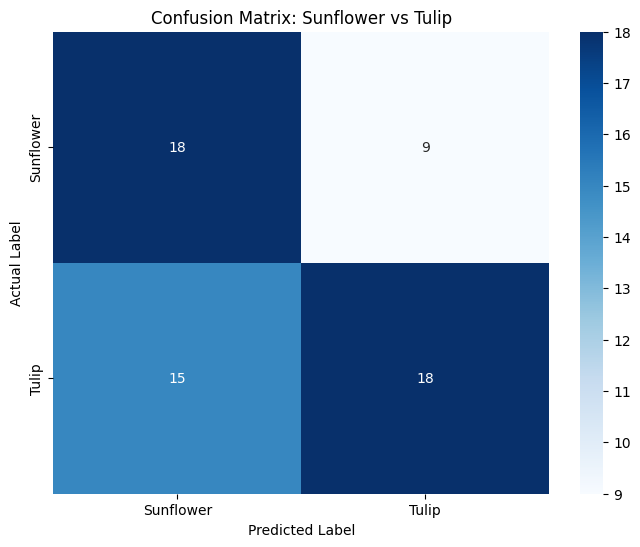

In [15]:
# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix: Sunflower vs Tulip')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

Increasing The epochs to train the ResNet to 100 with early stopping

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
# monitor='val_loss': Watch the validation loss
# patience=5: Wait for 5 epochs of no improvement before stopping
# restore_best_weights=True: Ensures the model keeps the version that performed best
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=100,  # You can increase max epochs because EarlyStopping will stop it anyway
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - accuracy: 0.5330 - loss: 0.8082 - val_accuracy: 0.5000 - val_loss: 0.6913
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.5211 - loss: 0.8741 - val_accuracy: 0.4500 - val_loss: 0.6995
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.4895 - loss: 0.8685 - val_accuracy: 0.4500 - val_loss: 0.7097
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.5790 - loss: 0.7238 - val_accuracy: 0.4500 - val_loss: 0.6959
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step - accuracy: 0.5063 - loss: 0.8216 - val_accuracy: 0.5833 - val_loss: 0.6849
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.5878 - loss: 0.7078 - val_accuracy: 0.6167 - val_loss: 0.6762
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step - accuracy: 0.5032 - loss: 0.7756 - val_accuracy: 0.5167 - val_loss: 0.6832
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.4935 - loss: 0.7863 - val_accuracy: 0.4667 - val_loss: 0.6928


In [29]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Re-create the validation generator WITHOUT shuffling
test_set = val_datagen.flow_from_dataframe(
    val_df,
    x_col='FileName',
    y_col='Category',
    batch_size=32,
    class_mode='categorical',
    target_size=(224, 224),
    shuffle=False  # Crucial for the report!
)

# 2. Get the raw predictions (probabilities)
Y_pred = model.predict(test_set)

# 3. Convert probabilities to class indices (0 or 1)
y_pred = np.argmax(Y_pred, axis=1)

# 4. Get the true labels from the generator
y_true = test_set.classes

# 5. Get the class names (Sunflower, Tulip)
target_names = list(test_set.class_indices.keys())

Found 60 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step


In [30]:
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

   Sunflower       0.63      0.81      0.71        27
       Tulip       0.80      0.61      0.69        33

    accuracy                           0.70        60
   macro avg       0.71      0.71      0.70        60
weighted avg       0.72      0.70      0.70        60



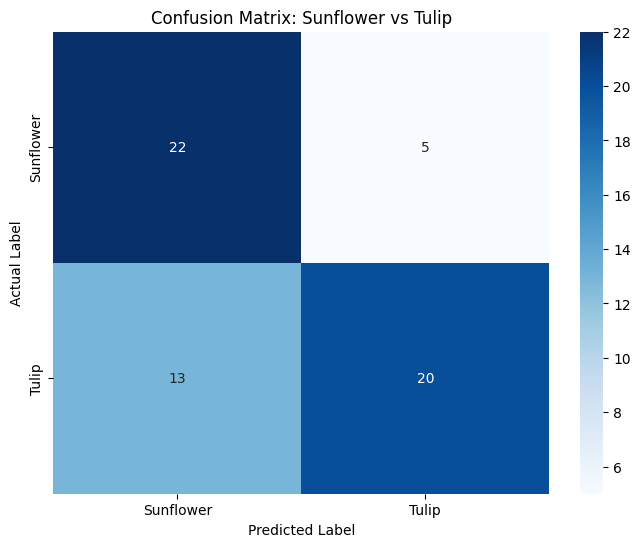

In [31]:
# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix: Sunflower vs Tulip')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
def get_thumbnail(path):
    try:
        img = Image.open(path)
        img.thumbnail((100, 100))
        buffered = BytesIO()
        img.save(buffered, format="JPEG")
        encoded_string = base64.b64encode(buffered.getvalue()).decode()
        return f'<img src="data:image/jpeg;base64,{encoded_string}" width="80">'
    except: return "Error"

# Create dataframe
results_df = pd.DataFrame({
    'Thumbnail': val_set.filepaths,
    'Actual': [target_names[i] for i in y_true],
    'Predicted': [target_names[i] for i in y_pred]
})

results_df['Status'] = results_df.apply(
    lambda x: '✅ Correct' if x['Actual'] == x['Predicted'] else '❌ Wrong', axis=1
)

# Render HTML
results_df['Thumbnail'] = results_df['Thumbnail'].map(get_thumbnail)
HTML(results_df.to_html(escape=False, index=False))